In [2]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 18.1MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 17.5MB/s 


In [3]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-02-24 08:32:34--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-02-24 08:32:34--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2aea1d93ed1c155ff9f2064b6e.dl.dropboxusercontent.com/cd/0/get/BJiaDe4R2m82PpzIWt4cvYfCSEdpGYG43OLFo_3ZcI5_momcVspLob5351q5q1j9DlX9Ckp0ifKaenGu1qvTOWhS3ZVPqk3awPPHOFM0e98-RL6-EvbwieW8JUVUnf4mCbQ/file?dl=1# [following]
--2021-02-24 08:32:34--  https://uc2aea1d93ed1c155ff9f2064b6e.dl.dropboxusercontent.com/cd/0/get/BJiaDe4R2m82PpzIWt4cvYfCSEdpGYG43OLFo_3ZcI5_momcVspLob5351q5q1j9DlX9Ckp0ifKaenGu1qvTOWhS3ZVPqk3awPPHOFM0e98-RL6-EvbwieW8JUVU

In [4]:
!unzip erm.zip

Archive:  erm.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/no/
  inflating: dataset/test/no/anonymized_1421704.jpg  
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  inflating: dataset/test/no/anonymized_324557.jpg  
  inflating: dataset/test/no/anonymized_492637.jpg

In [5]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [6]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [7]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [8]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [9]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='nasnet')
]

In [10]:
import timm
timm.list_models('*nasnet*')

['mnasnet_050',
 'mnasnet_075',
 'mnasnet_100',
 'mnasnet_140',
 'mnasnet_a1',
 'mnasnet_b1',
 'mnasnet_small',
 'nasnetalarge',
 'pnasnet5large',
 'semnasnet_050',
 'semnasnet_075',
 'semnasnet_100',
 'semnasnet_140',
 'spnasnet_100']

In [15]:
learn = timm_learner(dls512, 'mnasnet_050',cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Pretrained model URL is invalid, using random initialization.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=2.2908675418875646e-06)

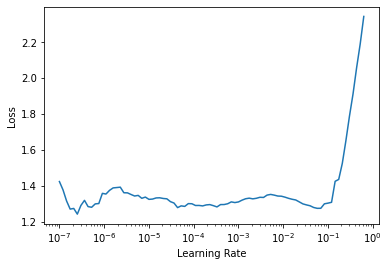

In [16]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.301588,0.873316,0.500000,0.537383,0.335277,00:22


Better model found at epoch 0 with valid_loss value: 0.8733161091804504.


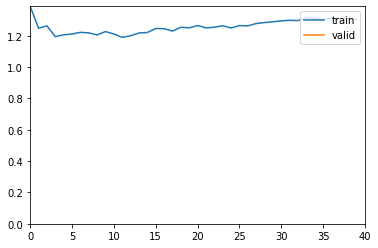

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.299670,0.958023,0.513761,0.534626,0.562682,00:23
1,1.302797,0.980105,0.480122,0.504373,0.504373,00:23
2,1.262850,0.961111,0.515290,0.536313,0.559767,00:23
3,1.286667,0.954242,0.500000,0.523121,0.527697,00:23
4,1.274428,0.979102,0.461774,0.487395,0.507289,00:23
5,1.249805,0.977047,0.478593,0.502762,0.530612,00:23
6,1.281066,0.895399,0.509174,0.529412,0.577259,00:23
7,1.267835,0.920907,0.478593,0.502924,0.501458,00:23
8,1.266785,0.961487,0.500000,0.521390,0.568513,00:23
9,1.276149,0.965364,0.495413,0.517241,0.568513,00:23


Better model found at epoch 0 with valid_loss value: 0.9580233097076416.


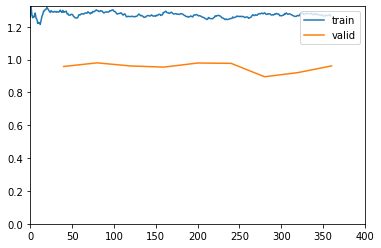

Better model found at epoch 3 with valid_loss value: 0.9542422294616699.
Better model found at epoch 6 with valid_loss value: 0.895399272441864.
No improvement since epoch 6: early stopping


In [17]:
learn.fine_tune(10,base_lr=1e-5)

In [18]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

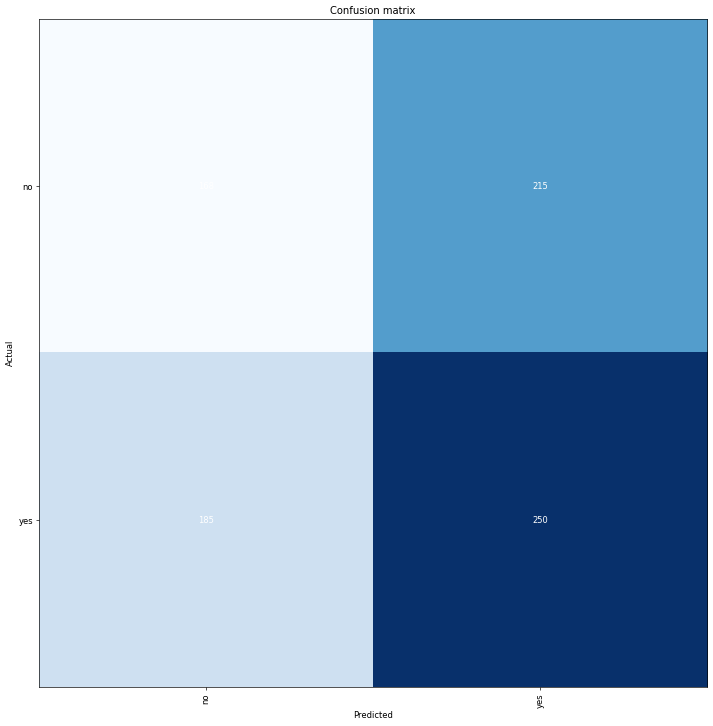

In [19]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [20]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5110024213790894.


(#4) [0.9211799502372742,0.5110024213790894,0.5376344086021505,0.5747126436781609]

In [21]:
learn.export(fname='resnet50.pkl')